In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader, natural_earth
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as mticker
from utils import move_last_two_months_first

def estimate_expected_sampling_loss(stds, n_samples):
    std = np.std(stds ** 2 / n_samples, axis=0)
    print("Maximum Standard Deviation of Variance: {}".format(np.max(std)))
    return np.mean(stds ** 2 / n_samples, axis=0)

def make_sampling_loss_figures(stds, n_samples):
    sample_loss = estimate_expected_sampling_loss(stds, n_samples)

    fig, axes = plt.subplots(6, 6, figsize=(20,15))
    fig.suptitle("Expected Sampling Loss for N={} decades".format(n_samples))
    for month in range(6):
        for category in range(6):
            ax = axes[month, category]
            ax.set_title(f"Month {month}, Category {category}")
            ax.axis('off')
            f=ax.imshow(sample_loss[:,:,month, category], vmin=0, vmax=0.01)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(f, cax=cbar_ax)
    plt.show()

def make_total_variance_figures(grids):
    variance = np.var(grids, axis=0)
    cat_max = {0: 0.03, 1: 0.004, 2: 0.001, 3: 0.0005 , 4: 0.0001, 5: 0.00001}
    for category in range(6):
        fig, axes = plt.subplots(1, 6, figsize=(20,15))
        fig.suptitle("Estimated Total Variance of Outputs")
        for month in range(6):
            ax = axes[month]
            ax.set_title(f"Month {month}, Category {category}")
            ax.axis('off')
            f = ax.imshow(variance[:,:,month, category], vmin=0, vmax=cat_max[category])

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(f, cax=cbar_ax)
        plt.show()
            
def make_relative_sampling_loss_figures(variance, sample_loss, n_samples):
    #variance = np.var(grids, axis=0)
    #sample_loss = estimate_expected_sampling_loss(stds, n_samples)
    month_strings = ["January", "February", "March", "April", "November", "December"]

    fig, axes = plt.subplots(5, 6, figsize=(20,15), layout="compressed")
    
    for category in range(1, 6):
        for month in range(6):
            ax = axes[category - 1, month]
            
            ax.set_xticks([])
            ax.set_yticks([])
            f = ax.imshow(sample_loss[:,:,month, category] / (variance[:,:,month, category] + 1e-10), vmin=0.00, vmax=1)

    for month in range(6):
        ax = axes[0, month]
        ax.set_title(month_strings[month], pad=15)
    
    for category in range(1, 6):
        ax = axes[category - 1, 0]
        ax.set_ylabel(f"Category {category}", rotation=0, labelpad=40)
        
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(f, ax=axes)
    plt.show()

def compute_total_output_variance_from_files_iteratively(data_folder):
    files = glob.glob(os.path.join(data_folder, "*.hdf5"))
    all_grids = []
    all_stds = []
    
    s1 = np.zeros((110, 210, 6, 6))
    s2 = np.zeros((110, 210, 6, 6))
    c = 0
    for file_path in files:
        with h5py.File(file_path, 'r+') as file:
            for grid in file['train_grids'][:,-1]:
                s1 += grid
                s2 += grid ** 2
                c += 1

    variance =  s2/c - (s1/c)**2

    return variance
    
def compute_sampling_loss_from_files_iteratively(data_folder, n_samples):
    files = glob.glob(os.path.join(data_folder, "*.hdf5"))
    
    s1 = np.zeros((110, 210, 6, 6))
    c = 0
    for file_path in files:
        with h5py.File(file_path, 'r+') as file:
            for std in file['train_stds'][:,-1]:
                s1 += std ** 2 / n_samples
                c += 1

    return s1/c


def make_years_to_relative_error_threshold_figure(variance, sample_loss_one, threshold):

    variance = move_last_two_months_first(variance)
    sample_loss_one = move_last_two_months_first(sample_loss_one)
    
    month_strings = ["November", "December", "January", "February", "March", "April"]

    fig, axes = plt.subplots(5, 6, figsize=(20,15), layout="compressed", subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

    # Add transparent land by creating a custom feature
    land_shp = natural_earth(resolution='110m', category='physical', name='land')
    land_feature = ShapelyFeature(Reader(land_shp).geometries(),
                                  ccrs.PlateCarree(), facecolor='lightgray', edgecolor='face', alpha=0.5)
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    
    # Add countries boundaries and labels
    countries_shp = natural_earth(resolution='50m', category='cultural', name='admin_0_countries')
    countries_feature = ShapelyFeature(Reader(countries_shp).geometries(), ccrs.PlateCarree(),
                                       facecolor='none', edgecolor='black', linewidth=1, alpha=1)
    
    pc = np.empty((5, 6), dtype=object)
    for category in range(1, 6):
        for month in range(6):
            
            ax = axes[category - 1, month]
            ax.add_feature(land_feature)
            ax.add_feature(countries_feature)
            ax.add_feature(states_provinces, edgecolor='gray')

            ax.set_xticks([])
            ax.set_yticks([])

            val = (sample_loss_one[:,:,month, category] + 1e-13) / (threshold*(variance[:,:,month, category]) + 1e-10)

            # Plot gradient for model prediction on top of the land feature
            lonplot2 = np.linspace(135, 240, val.shape[1])
            latplot2 = np.linspace(-5, -60, val.shape[0])
            
            # Use a continuous colormap
            pc[category-1][month] = ax.contourf(lonplot2, latplot2, val, levels=100, cmap='summer', transform=ccrs.PlateCarree(), vmin=0, vmax=1000)
            
            gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                              linewidth=1, color='white', alpha=0.3, linestyle='--')
            gl.top_labels = False
            gl.right_labels = False
            ax.set_extent([135, 240, -60, -5], crs=ccrs.PlateCarree())

    for month in range(6):
        ax = axes[0, month]
        ax.set_title(month_strings[month], pad=15)
        # Add gridlines with labels
        
        
        gl.xlocator = mticker.FixedLocator([-180, -160, -140, -90, -45, 0, 45, 90, 140, 160, 180, 225, 270, 315, 360])
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 12, 'color': 'black'}
        gl.ylabel_style = {'size': 12, 'color': 'black'}
            
        # Adjust map extent to focus on the region of interest
    
    for category in range(1, 6):
        ax = axes[category - 1, 0]
        ax.set_ylabel(f"Category {category}", rotation=0, ha='right', labelpad=50)

        fig.colorbar(pc[category-1][2], ax=axes[category-1, :])
        
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    plt.show()
    
def get_all_data(data_folder):
    files = glob.glob(os.path.join(data_folder, "*.hdf5"))
    all_grids = []
    all_stds = []
    for file_path in files:
        with h5py.File(file_path, 'r+') as file:
            grids = file['train_grids']
            grids = list(np.array(grids[:,-1]))
            stds = list(np.array(file['train_stds'][:,-1]))

            all_grids += grids
            all_stds += stds

    return np.array(all_grids), np.array(all_stds)

data_folder  = "/users/ewinkelm/data/ewinkelm/"


In [2]:
var = compute_total_output_variance_from_files_iteratively(data_folder)

In [3]:
loss = compute_sampling_loss_from_files_iteratively(data_folder, 1)

In [2]:
make_relative_sampling_loss_figures(np.flipud(var), np.flipud(loss/1000), 1000)

NameError: name 'var' is not defined

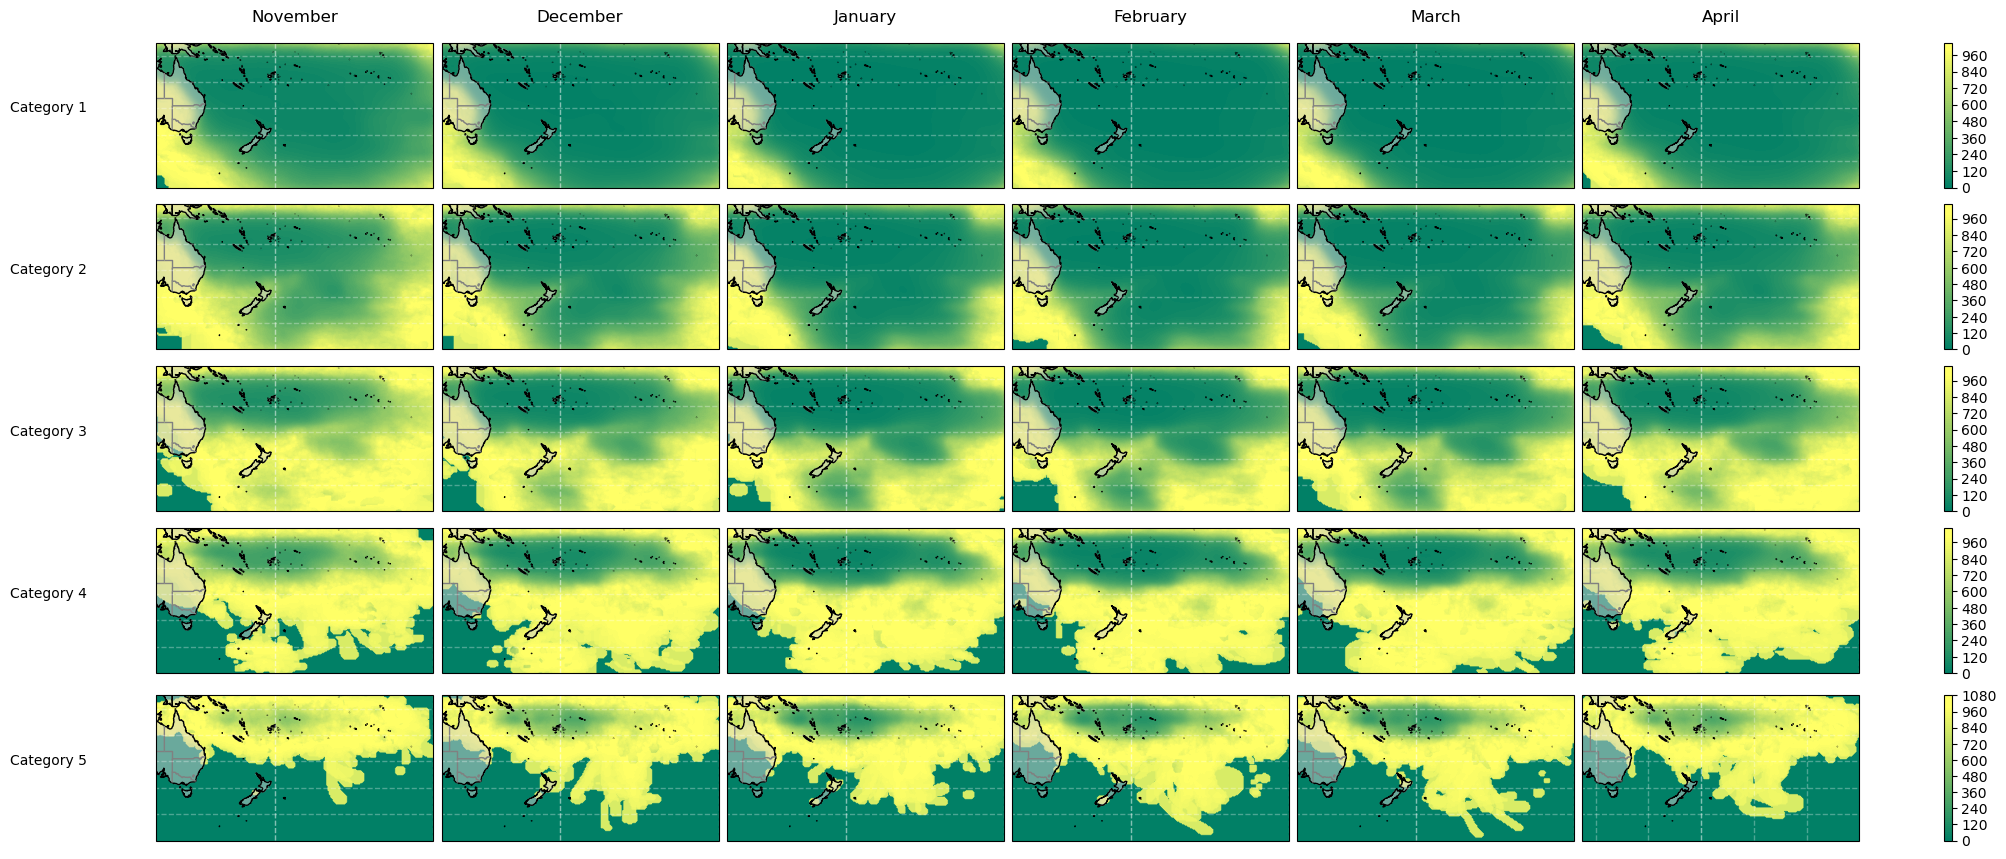

In [4]:
make_years_to_relative_error_threshold_figure(np.flipud(var), np.flipud(loss), 1)

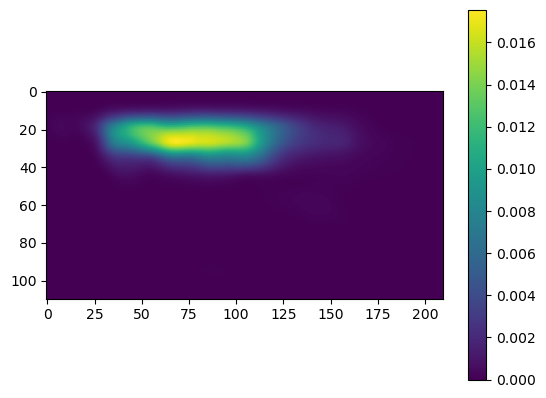

In [6]:
plt.imshow(np.flipud(np.sum(var[:,:,:,3:6], axis=(-1,-2))))
plt.colorbar()